In [1]:
#Boolean value to determine if we want to use the api to update the stored bitcoin values
Update = False

# Simple Bitcoin predictive Model

## Imports & API

### Imports

In [2]:
import json
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")

#scrap / API
#import praw
import requests 

#Sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Testing Stationarity
from statsmodels import tsa

#LSTM RNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open('keys.json') as f:
    key = json.loads(f.read())

### Functions

In [4]:
def plot_eda(eda,*args):
    
    fig = plt.figure(figsize=[15, 10])
    plt.suptitle('{} exchanges values vs {} perception via Reddit'.format(c_,c_))

    plt.subplot(221)
    plt.plot(eda.Bitcoin.resample('d').mean())
    plt.title('BitCoin Closing Value, by day')
    plt.ylim(0,20000)
    plt.ylabel('USD')
    plt.xlabel('Date');

    plt.subplot(222)
    plt.plot(eda.Bitcoin.resample('w').mean())
    plt.title('BitCoin Closing Value, mean by week')
    plt.ylim(0,20000)
    plt.ylabel('USD')
    plt.xlabel('Date');
    
    if 'scale' in args:

        plt.subplot(223)
        plt.plot(eda.pos_s.resample('d').mean(),c='blue',label='Scaled Postive Sentiment')
        plt.plot(eda.neg_s.resample('d').mean(),c='red',label='Scaled Negative Sentiment')
        plt.title('BitCoin Reddit Scaled Sentiment, by day')
        plt.ylim(0,15000)
        plt.ylabel('Sentiment x Score')
        plt.xlabel('Date');
        plt.legend()

        plt.subplot(224)
        plt.plot(eda.pos_s.resample('w').mean(),c='blue',label='Scaled Postive Sentiment')
        plt.plot(eda.neg_s.resample('w').mean(),c='red',label='Scaled Negative Seniment')
        plt.title('BitCoin Reddit Scaled Sentiment, mean by week')
        plt.ylim(0,15000)
        plt.ylabel('Sentiment x Score')
        plt.xlabel('Date');
        plt.legend()


    elif 'count' in args:

        plt.subplot(223)
        plt.plot(eda.pos_ohe.resample('d').mean(),c='blue',label='Postive Count')
        plt.plot(eda.neg_ohe.resample('d').mean(),c='red',label='Negative Count')
        plt.title('BitCoin Reddit Sentiment Count, by day')
        plt.ylim(0,1000)
        plt.ylabel('Count')
        plt.xlabel('Date');
        plt.legend()

        plt.subplot(224)
        plt.plot(eda.pos_ohe.resample('w').mean(),c='blue',label='Postive Count')
        plt.plot(eda.neg_ohe.resample('w').mean(),c='red',label='Negative Count')
        plt.title('BitCoin Reddit Sentiment Count, mean by week')
        plt.ylim(0,1000)
        plt.ylabel('Count')
        plt.xlabel('Date');
        plt.legend()

    else:
        pass
    plt.show()
    return

### BitCoin Market API Fetching & Cleaning

Variables of note: <br>
```c_code``` = Crypto value's code <br>
```c_market``` = Crypto value's market <br>
```c_``` = Cryto value's common name <br>
```crypto.columns = ['open','high','low','close','volume','cap']```

In [5]:
#declaring Fetch parameters
c_code = 'BTC'
c_market = 'USD'

if Update:
    #Fetching Data
    cryptos = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}".format(c_code,c_market,key['bit_api_key']))

    #Assigning "name" for ease
    c_ = cryptos.json()['Meta Data']['3. Digital Currency Name']

    #Organizing Data
    crypto = pd.DataFrame.from_dict(cryptos.json()['Time Series (Digital Currency Daily)'],orient='index',dtype='float')
    crypto = crypto.drop(['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    crypto.columns = ['open','high','low','close','volume','cap']
    crypto.index = pd.to_datetime(crypto.index)

    #Cleaning Missing Data
    print("There are {} days between the first and last time stamp, the API captured {} days.".format(str(crypto.index[-1] - crypto.index[0]).split(" ")[0],len(crypto)))

    if int(str(crypto.index[-1] - crypto.index[0]).split(" ")[0]) - len(crypto) > 5:
        idx = pd.date_range(crypto.index[0], crypto.index[-1])
        crypto = crypto.reindex(idx, fill_value=np.nan)
        print("So we will need to interpolate the {} missing days.".format(crypto.isnull().sum()[0]))
        crypto = crypto.interpolate()
    else:
        print("as such we dont need to interpolate any missing days")

    crypto.to_csv('./Data/Market.csv')

else:
    #will import last fetched csv
    c_ = c_code
    crypto = pd.read_csv('./Data/Market.csv',index_col=0)
    crypto.index = pd.to_datetime(crypto.index)

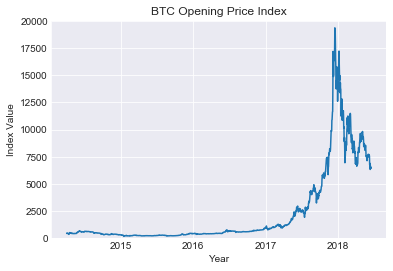

In [6]:
#Sanity Check
crypto.open.plot()
plt.title('{} Opening Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

### Reddit

In [7]:
reddit = pd.read_csv('./Data/Reddit_Crypto-Copy1.csv')

reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date']).dt.date

sia = SentimentIntensityAnalyzer()

reddit_sent = pd.DataFrame(columns=['compound','neg','neu','pos'],index=None)
results = []
for sentence in tqdm(reddit.title):
    ss = sia.polarity_scores(sentence)
    results.append(ss)
reddit_sent = reddit_sent.append(results)

reddit = reddit.merge(reddit_sent,left_index=True,right_index=True)

#sentiment scaled by score of post
reddit['neg_s'] = reddit['neg']*reddit['score']
reddit['pos_s'] = reddit['pos']*reddit['score']
reddit['neu_s'] = reddit['neu']*reddit['score']

#one hot encoded pos score col
reddit['neg_ohe'] = reddit['pos'] - reddit['neg']
reddit['pos_ohe'] = reddit['neg_ohe'].apply(lambda x: 1 if x>0 else 0)
reddit['eg_ohe'] = reddit['neg_ohe'].apply(lambda x: 1 if x<=0 else 0)

#tqdm

100%|██████████| 82170/82170 [00:32<00:00, 2530.12it/s]


In [8]:
eda = pd.DataFrame(reddit.groupby('date')['pos_ohe','neg_ohe','pos_s','neg_s'].sum())
eda['Bitcoin'] = crypto.close
eda.index = pd.to_datetime(eda.index)

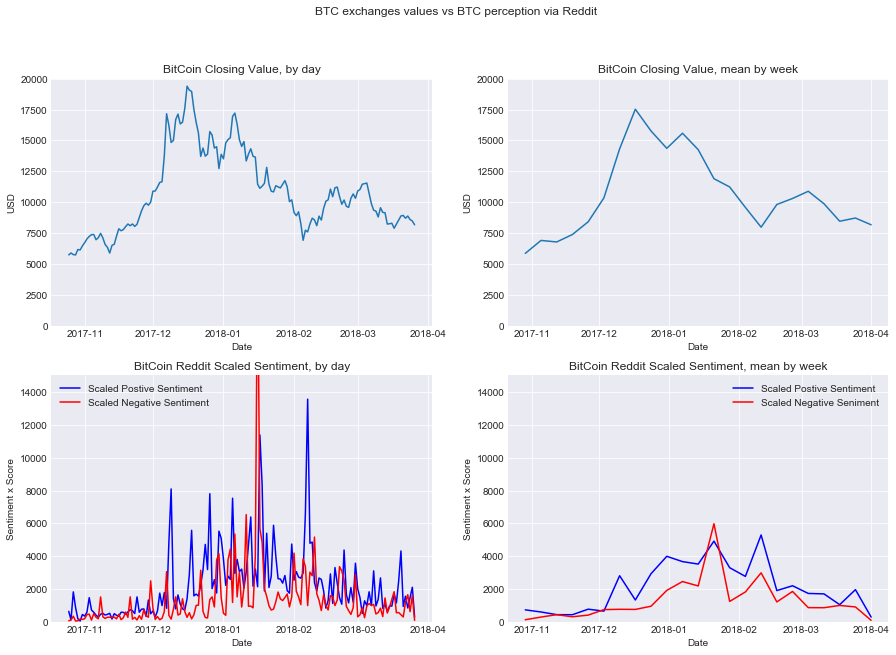

In [9]:
plot_eda(eda,'scale')

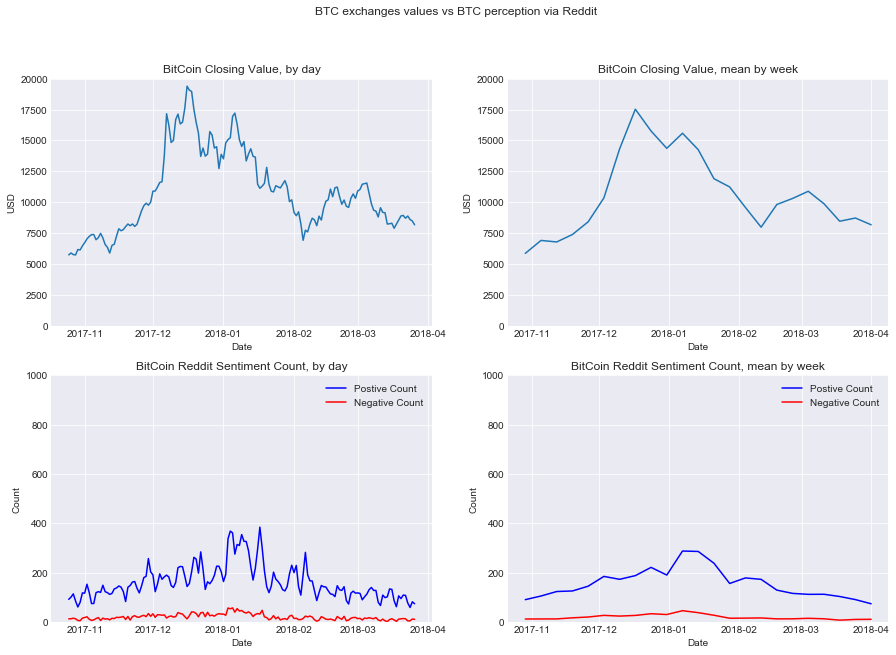

In [10]:
plot_eda(eda,'count')

In [11]:
#I am only doing the number of comments per day in the cryt subreddit

reddit = pd.DataFrame(reddit.groupby('date')['comments','score','neg_s','pos_s','neg_ohe','pos_ohe'].sum())
reddit.index = pd.to_datetime(reddit.index)

In [12]:
#Cleaning Missing Data
print("There are {} days between the first and last time stamp, however our API captured {} days.".format(str(reddit.index[-1] - reddit.index[0]).split(" ")[0],len(reddit)))

if int(str(reddit.index[-1] - reddit.index[0]).split(" ")[0]) - len(reddit) > 5:
    idx = pd.date_range(reddit.index[0], reddit.index[-1])
    reddit = reddit.reindex(idx, fill_value=np.nan)
    print("So we will need to interpolate the {} missing days.".format(reddit.isnull().sum()[0]))
    reddit = reddit.interpolate()
else:
    print("as such we dont need to interpolate any missing days")

There are 152 days between the first and last time stamp, however our API captured 153 days.
as such we dont need to interpolate any missing days


In [13]:
#I will eventually implment a predictor comparing reddit comments with the values
#bit = bit.join(reddit)

In [14]:
crypto = crypto.merge(reddit,left_index=True, right_index=True,how='left')

## Preliminary EDA

First off let us resample the entire Bitcoin opening value Dataset by: 

```
Daily means
Weekly means
Monthly means
Yearly means```

In [15]:
df_daily = crypto.resample('D').mean()

# Resampling to weekly frequency
df_week = crypto.resample('W').mean()

# Resampling to monthly frequency
df_month = crypto.resample('M').mean()

# Resampling to annual frequency
df_year = crypto.resample('A-DEC').mean()

# Resampling to quarterly frequency
#df_Q = crypto.resample('Q-DEC').mean()

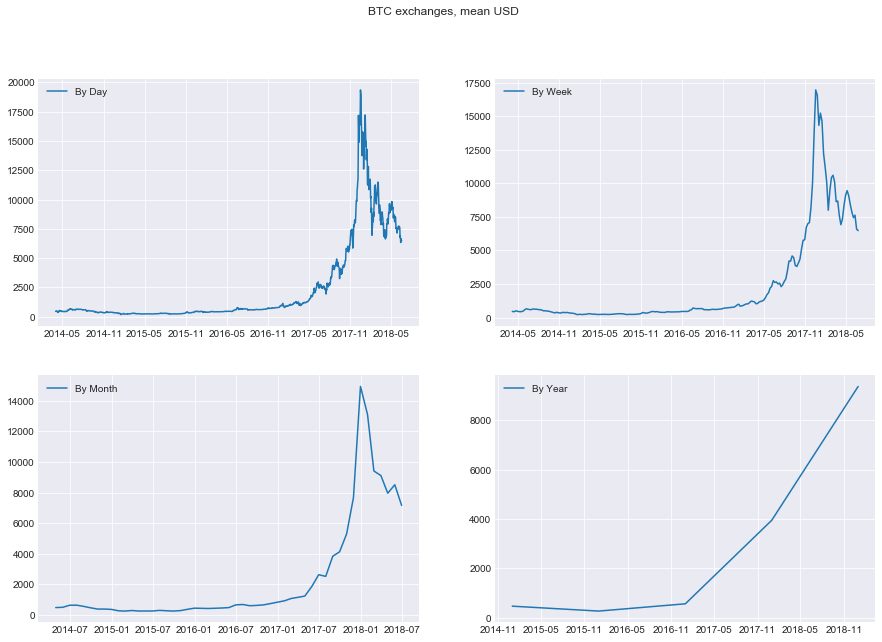

In [16]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))

for i,j in enumerate(['Day','Week','Month','Year']):
    temp = [df_daily,df_week,df_month,df_year]
    plt.subplot(221+i)
    plt.plot(temp[i].open,'-', label='By {}'.format(j))
    plt.legend()
plt.show()

## More_Rel

The lagging tail from 2014-2016 will likely be a problem.

As to avoid having more weight given to the time during which Bitcoin was worthless.
- ```more_rel``` will be a timeseries after Oct.25.2017, once Bitcoin has become 'more relivant'


- The reasoning being:

"Bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

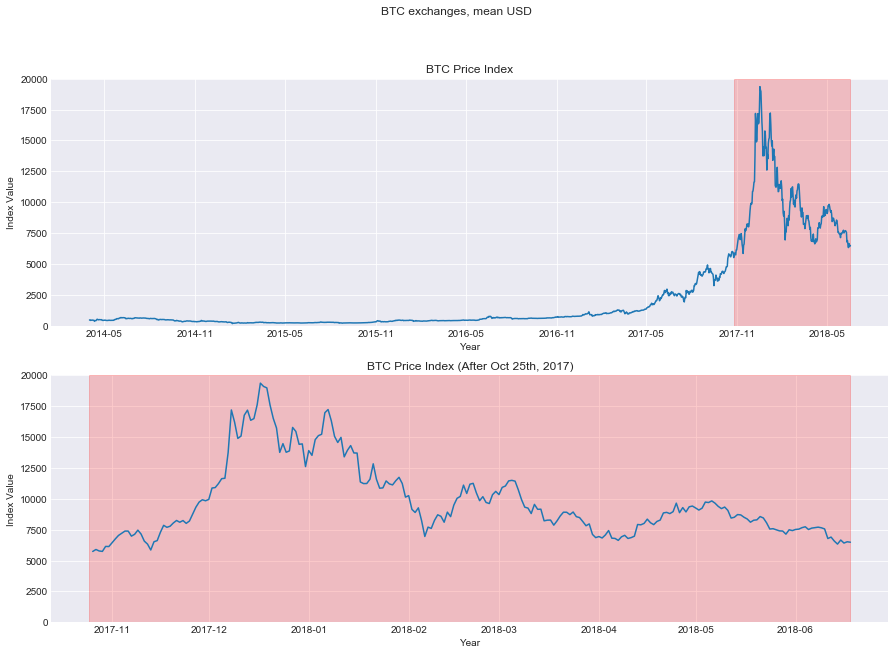

In [17]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))

plt.subplot(211)
plt.plot(crypto['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)

plt.title('{} Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year')

plt.subplot(212)
plt.plot(crypto[crypto.index>'2017-10-25']['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)

plt.title('{} Price Index (After Oct 25th, 2017)'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

plt.show()

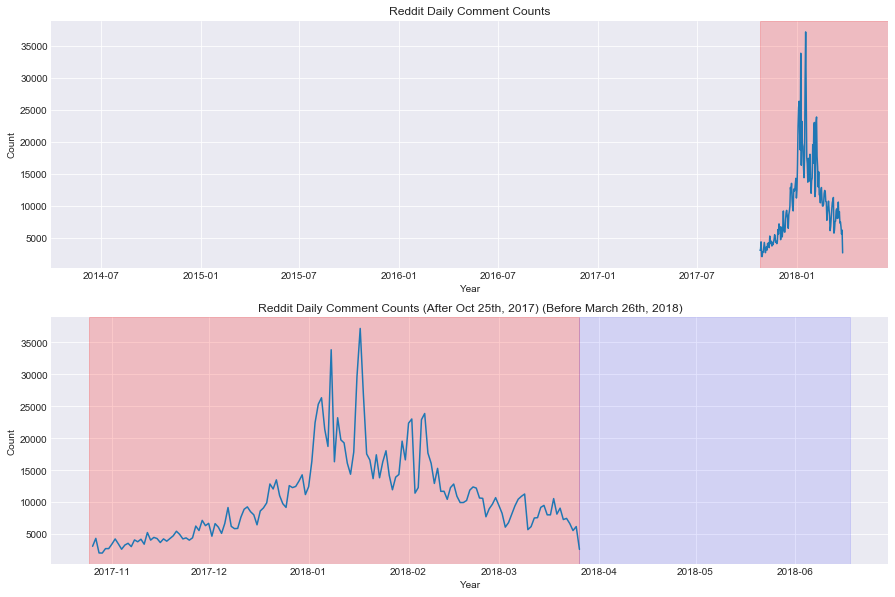

In [18]:
fig = plt.figure(figsize=[15, 10])

plt.subplot(211)
plt.plot(crypto['comments'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)
plt.xlim(crypto.index[0],crypto.index[-1])
plt.title('Reddit Daily Comment Counts'.format(c_))
plt.ylabel('Count')
plt.xlabel('Year')

plt.subplot(212)
plt.plot(crypto[crypto.index>'2017-10-25']['comments'], '-', label='By Days')
plt.axvspan('2017-10-25', reddit.index[-1], color='red', alpha=0.2)

plt.axvspan(reddit.index[-1], crypto.index[-1], color='blue', alpha=0.1)
plt.title('Reddit Daily Comment Counts (After Oct 25th, 2017) (Before March 26th, 2018)'.format(c_))
plt.ylabel('Count')
plt.xlabel('Year');

plt.show()

In [19]:
crypto = crypto.dropna()

#### Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

## LSTM RNN

#### Here we aim to use ```open``` to predict ```open```

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

First our data needs to be scaled before being split
    - Otherwise the values at time n would be not properly scaled to the min and max of the data at time n-

In [20]:
split_date = '2018-03-01'

train = crypto.open[crypto.index<split_date]
test = crypto.open[crypto.index>=split_date]

print('Training set consists of {}% of data'.format(round(train.shape[0]/crypto.shape[0],2)*100))

Training set consists of 83.0% of data


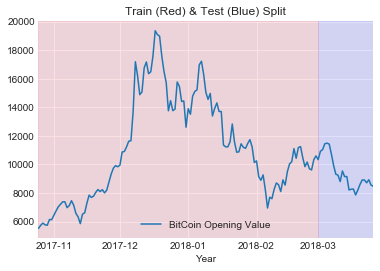

In [21]:
plt.plot(crypto[['open']], '-', label='By Days')
plt.axvspan(crypto.index[0], split_date, color='red', alpha=0.1)
plt.axvspan(split_date, crypto.index[-1], color='blue', alpha=0.1)
plt.xlim(crypto.index[0],crypto.index[-1])
plt.title('Train (Red) & Test (Blue) Split'.format(c_))
plt.legend(['BitCoin Opening Value'])
plt.xlabel('Year');

## Uni-Variate LSTM

In [22]:
#NN need values between 0-1
mm = MinMaxScaler()

#mm scalers need to match in shape
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

test = np.reshape(test.values, (len(test),1))
test = mm.transform(test)

#here we are predicting Q days ahead
Q = 1
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

X_test = test[0:len(test)-Q]
y_test = test[Q:len(test)]

X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [23]:
X_train.shape

(126, 1, 1)

In [24]:
y_train.shape

(126, 1)

In [25]:
X_test.shape

(25, 1, 1)

In [26]:
y_test.shape

(25, 1)

In [27]:
Uni_LSTM = 'reset'
# design network
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mae')
# fit network
history_uni = Uni_LSTM.fit(X_train, y_train, batch_size=1, epochs=50, 
                           validation_data=(X_test, y_test), verbose=1)

Train on 126 samples, validate on 25 samples
Epoch 1/50
126/126 [==============================] - 5s 42ms/step - loss: 0.2225 - val_loss: 0.1017
Epoch 2/50
126/126 [==============================] - 3s 25ms/step - loss: 0.1070 - val_loss: 0.0683
Epoch 3/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0660 - val_loss: 0.0272
Epoch 4/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0487 - val_loss: 0.0281
Epoch 5/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0460 - val_loss: 0.0260
Epoch 6/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0463 - val_loss: 0.0264
Epoch 7/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0452 - val_loss: 0.0237
Epoch 8/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0450 - val_loss: 0.0243
Epoch 9/50
126/126 [==============================] - 3s 26ms/step - loss: 0.0437 - val_loss: 0.0246
Epoch 10/50
126/126 [=========================

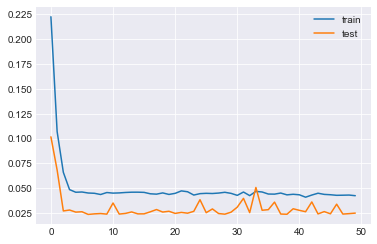

In [28]:
# plot history
plt.plot(history_uni.history['loss'], label='train')
plt.plot(history_uni.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
predicted_BTC_price = Uni_LSTM.predict(X_test)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

y_true = mm.inverse_transform(y_test)

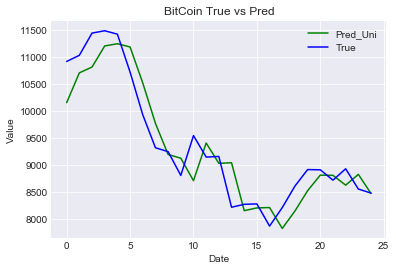

In [30]:
pred_uni = pd.DataFrame({'True':y_true.flatten(),'Pred_Uni':predicted_BTC_price.flatten()})

pred_uni.Pred_Uni.plot(c='green')
pred_uni['True'].plot(c='blue')
plt.legend()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

In [31]:
#percent change per day, difference between
pct_ch = pred_uni.pct_change()[1:]
pct_ch = pct_ch[1:]
pct_ch['dif'] = pct_ch['True'] - pct_ch['Pred_Uni']
pct_ch['Tr'] = 0

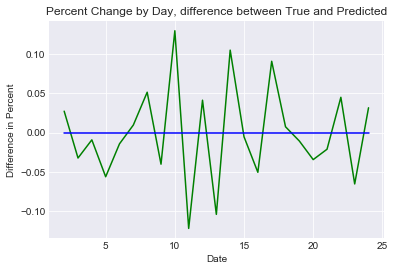

In [32]:
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date');
pct_ch.dif.plot(c='green')
pct_ch.Tr.plot(c='blue');

- This likely tells us that for the most part the NN assumes the value of bitcoin will remain more stable than it usually does (considering bitcoin's volitile nature)
- This can be remedied by:
    - Increasing the # of feature by which it is calculating the values
    - Adjust the memory that the NN fetchs from in the LSTM cells
    - Train more
        - the fear with that comes from overfitting to pre-existing trends which would ultimately do no more than say 'the score is basically yesterday's score'

## Multi-Variate LSTM RNN

In [34]:
#split_date = '2018-03-01'

#because of how correlated 'close' on day n, relates with 'open' on day n+1, removing 'close'
train = crypto.drop(['close'],axis=1)[crypto.index<split_date]
test = crypto.drop(['close'],axis=1)[crypto.index>=split_date]

In [35]:
#NN need values between 0-1
mm = MinMaxScaler()

#mm scalers need to match in shape
train = np.reshape(train.values, (train.shape[0], train.shape[1]))
train = mm.fit_transform(train)

test = np.reshape(test.values, (test.shape[0], test.shape[1]))
test = mm.transform(test)

#here we are predicting Q days ahead
Q = 1
X_train = train[0:len(train)-Q]
y_train = train[:,0][Q:len(train)] #0th column is the opening on the next day

X_test = test[0:len(test)-Q]
y_test = test[:,0][Q:len(test)]

#reshaping all data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [36]:
Multi_LSTM = 'reset'
# design network

Multi_LSTM = Sequential()
Multi_LSTM.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Multi_LSTM.add(Dense(1))
Multi_LSTM.compile(optimizer='adam', loss='mae')
# fit network
history_multi = Multi_LSTM.fit(X_train, y_train, batch_size=1, epochs=50, 
                           validation_data=(X_test, y_test), verbose=1)

Train on 126 samples, validate on 25 samples
Epoch 1/50
126/126 [==============================] - 5s 39ms/step - loss: 0.1426 - val_loss: 0.0342
Epoch 2/50
126/126 [==============================] - 3s 23ms/step - loss: 0.0453 - val_loss: 0.0269
Epoch 3/50
126/126 [==============================] - 3s 24ms/step - loss: 0.0360 - val_loss: 0.0232
Epoch 4/50
126/126 [==============================] - 3s 22ms/step - loss: 0.0357 - val_loss: 0.0246
Epoch 5/50
126/126 [==============================] - 3s 23ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 6/50
126/126 [==============================] - 3s 23ms/step - loss: 0.0294 - val_loss: 0.0220
Epoch 7/50
126/126 [==============================] - 3s 22ms/step - loss: 0.0306 - val_loss: 0.0204
Epoch 8/50
126/126 [==============================] - 3s 24ms/step - loss: 0.0286 - val_loss: 0.0190
Epoch 9/50
126/126 [==============================] - 3s 23ms/step - loss: 0.0278 - val_loss: 0.0257
Epoch 10/50
126/126 [=========================

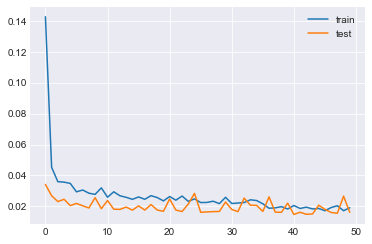

In [37]:
# plot history
plt.plot(history_multi.history['loss'], label='train')
plt.plot(history_multi.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
mm2 = MinMaxScaler()
train = crypto.drop(['close'],axis=1)[crypto.index<split_date]
temp = np.reshape(train['open'].values,(train['open'].shape[0],1)).copy()
mm2.fit(temp)s

MinMaxScaler(copy=True, feature_range=(0, 1))

In [39]:
predicted_BTC_price = Multi_LSTM.predict(X_test)
predicted_BTC_price = mm2.inverse_transform(predicted_BTC_price)[:,0]

y_true = mm2.inverse_transform(y_test)

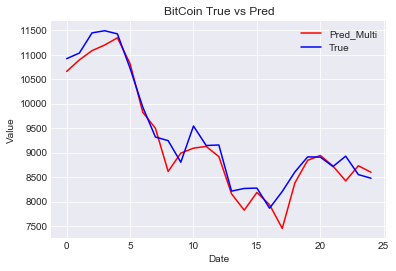

In [42]:
pred_multi = pd.DataFrame({'True':y_true.flatten(),'Pred_Multi':predicted_BTC_price.flatten()})

pred_multi.Pred_Multi.plot(c='red')
pred_multi['True'].plot(c='blue')
plt.legend()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

In [43]:
#percent change per day, difference between
pct_ch2 = pred_multi.pct_change()[1:]
pct_ch2 = pct_ch2[1:]

In [44]:
pct_ch2['dif'] = pct_ch2['True'] - pct_ch2['Pred_Multi']
pct_ch2['Tr'] = 0

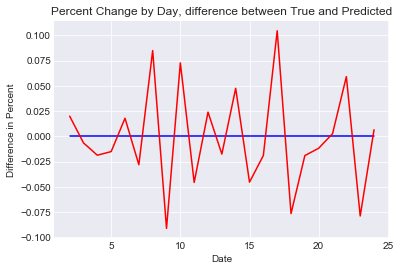

In [49]:
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
pct_ch2.Tr.plot(c='blue')
pct_ch2.dif.plot(c='red');

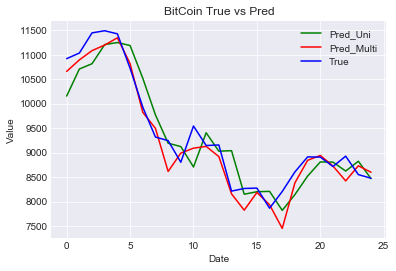

In [46]:
pred_uni.Pred_Uni.plot(c='green')
pred_multi.Pred_Multi.plot(c='red')
pred_multi['True'].plot(c='blue')
plt.legend()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

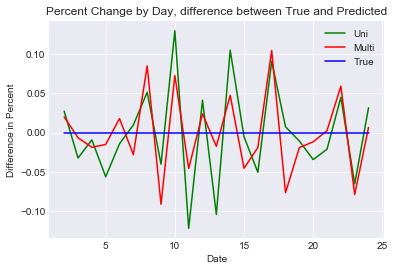

In [47]:
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
pct_ch.dif.plot(c='green')
pct_ch2.dif.plot(c='red')
pct_ch2.Tr.plot(c='blue')
plt.legend(['Uni','Multi','True']);